# Eigen Portfolio para la gestion de activos
El objetivo de este estudio de caso es usar técnicas de reducción dimensional para la construccion y gestion de portafolios.

In [ ]:
# 1. Definicion del problema

Nuestro objetivo en este estudio es encontrar una cartera que supere el performance de un indice utilizando un algoritmo basado en la reduccion dimensional sobre un dataset de acciones para determinar la asignacion de capital a los diferentes activos.

La data utilizada para proviene del Dow Jones Industrial Average (DJIA) y sus respectivas 30 acciones. El conjunto de datos se puede descargar con Yahoo Finance.

# 2. Cargar paquetes y data de trabajo

In [4]:
# descargar data financiera
import yfinance as yfinance
from yahoofinancials import YahooFinancials

# operaciones y tablas
import numpy as np
import pandas as pd
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix

# visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

# preprocesamiento
from sklearn.preprocessing import StandardScaler

# algoritmo de reduccion dimensional
from sklearn.decomposition import PCA
from numpy.linalg import inv, eig, svd

## Cargar data

In [8]:
raw_data = read_csv('inputs/djia_adjusted_closes.csv', index_col=0)
raw_data.head()

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,DWDP,...,NKE,PFE,PG,TRV,UTX,UNH,VZ,V,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,29.847043,35.476634,3.530576,26.650218,14.560887,21.582046,43.003876,16.983583,23.522220,NaN,...,4.701180,16.746856,32.227726,20.158885,21.319030,5.841355,22.564221,NaN,47.337599,21.713237
2000-01-04,28.661131,34.134275,3.232839,26.610431,14.372251,21.582046,40.577200,17.040950,24.899860,NaN,...,4.445214,16.121738,31.596399,19.890099,20.445803,5.766368,21.833915,NaN,45.566248,20.907354
2000-01-05,30.122175,33.959430,3.280149,28.473758,14.914205,22.049145,40.895453,17.228147,25.781550,NaN,...,4.702157,16.415912,31.325831,20.085579,20.254784,5.753327,22.564221,NaN,44.503437,21.097421
2000-01-06,31.877325,33.959430,2.996290,28.553331,15.459153,22.903343,39.781569,17.210031,24.899860,NaN,...,4.677733,16.972739,32.438168,20.122232,20.998392,5.964159,22.449405,NaN,45.126952,20.527220
2000-01-07,32.509812,34.433913,3.138219,29.382213,15.962182,23.305926,42.128682,18.342270,24.506249,NaN,...,4.677733,18.123166,35.023602,20.922479,21.830687,6.662948,22.282692,NaN,48.535033,21.051805


In [3]:
import warnings
warnings.filterwarnings('ignore')

# 3. Analisis exploratorio

In [256]:
dataset = raw_data.copy()
dataset = dataset.sort_index(ascending=True)
dataset.head()

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,DWDP,...,NKE,PFE,PG,TRV,UTX,UNH,VZ,V,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,29.847043,35.476634,3.530576,26.650218,14.560887,21.582046,43.003876,16.983583,23.522220,NaN,...,4.701180,16.746856,32.227726,20.158885,21.319030,5.841355,22.564221,NaN,47.337599,21.713237
2000-01-04,28.661131,34.134275,3.232839,26.610431,14.372251,21.582046,40.577200,17.040950,24.899860,NaN,...,4.445214,16.121738,31.596399,19.890099,20.445803,5.766368,21.833915,NaN,45.566248,20.907354
2000-01-05,30.122175,33.959430,3.280149,28.473758,14.914205,22.049145,40.895453,17.228147,25.781550,NaN,...,4.702157,16.415912,31.325831,20.085579,20.254784,5.753327,22.564221,NaN,44.503437,21.097421
2000-01-06,31.877325,33.959430,2.996290,28.553331,15.459153,22.903343,39.781569,17.210031,24.899860,NaN,...,4.677733,16.972739,32.438168,20.122232,20.998392,5.964159,22.449405,NaN,45.126952,20.527220
2000-01-07,32.509812,34.433913,3.138219,29.382213,15.962182,23.305926,42.128682,18.342270,24.506249,NaN,...,4.677733,18.123166,35.023602,20.922479,21.830687,6.662948,22.282692,NaN,48.535033,21.051805


In [257]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4804 entries, 2000-01-03 to 2019-02-06
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MMM     4804 non-null   float64
 1   AXP     4804 non-null   float64
 2   AAPL    4804 non-null   float64
 3   BA      4804 non-null   float64
 4   CAT     4804 non-null   float64
 5   CVX     4804 non-null   float64
 6   CSCO    4804 non-null   float64
 7   KO      4804 non-null   float64
 8   DIS     4804 non-null   float64
 9   DWDP    363 non-null    float64
 10  XOM     4804 non-null   float64
 11  GS      4804 non-null   float64
 12  HD      4804 non-null   float64
 13  IBM     4804 non-null   float64
 14  INTC    4804 non-null   float64
 15  JNJ     4804 non-null   float64
 16  JPM     4804 non-null   float64
 17  MCD     4804 non-null   float64
 18  MRK     4804 non-null   float64
 19  MSFT    4804 non-null   float64
 20  NKE     4804 non-null   float64
 21  PFE     4804 non-null   flo

Analicemos las correlaciones de los precios de las acciones:

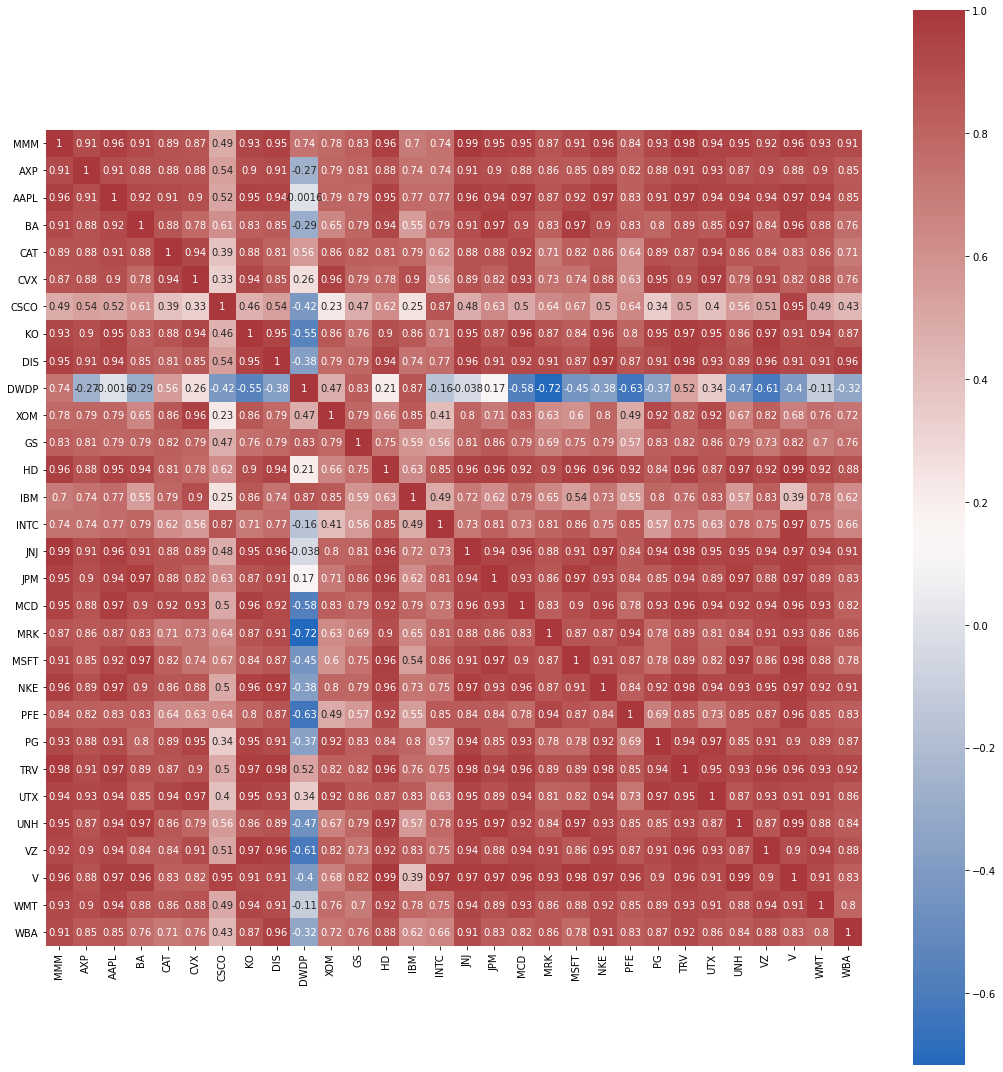

In [258]:
correlation = dataset.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='vlag')
plt.tight_layout()

Se observa una significativa correlacion positiva de los precios de las acciones.

# 4. Preparacion de la data

Primero eliminaremos las columnas con alta proporcion de missing.

### Missings

In [259]:
proporcion_missing = dataset.isnull().mean().sort_values(ascending=False)
proporcion_missing.head(10)

DWDP    0.924438
V       0.429434
MMM     0.000000
JPM     0.000000
WMT     0.000000
VZ      0.000000
UNH     0.000000
UTX     0.000000
TRV     0.000000
PG      0.000000
dtype: float64

In [260]:
cond = proporcion_missing > 0
drop_list = list(proporcion_missing.loc[cond].index)
drop_list

['DWDP', 'V']

In [261]:
dataset = dataset.drop(labels=drop_list, axis=1)
dataset.shape

(4804, 28)

No hay mas missing en las observaciones, pero una forma de imputar en caso de data diaria (o mayor frecuencia) seria asignando el ultimo valor. Una alternativa es usar el promedio.

In [262]:
# dataset = dataset.fillna(method='ffill')

In [263]:
# Ejemplo de inputacion forward fill (recomendable cuando hay NAs en data de alta frecuencia)
hourly_cls_price = pd.Series([4.3, 4.7, np.nan, 5.2])
print(hourly_cls_price, '\n') # data con Nas
print(hourly_cls_price.fillna(method='ffill'))  # data imputada

0    4.3
1    4.7
2    NaN
3    5.2
dtype: float64 

0    4.3
1    4.7
2    4.7
3    5.2
dtype: float64


### Calcular retornos

Finalmente, el centro del analisis esta en los reotrnos de las acciones y su volatilidad en una temporalidad dada. En este caso, se analizaran los retornos lineales diarios (variacion % intradiaria de los precios de las acciones).

El medodo `.pct_change()` de Pandas calcula la variacion porcentual en las observaciones de cada columna. Muy conveniente para el calulo de retornos. 

In [266]:
datareturns = dataset.pct_change(periods=1)

# remover outliers (mas de 3 desviaciones estandar de diferencia)
# datareturns= datareturns[datareturns.apply(lambda x:(x - x.mean()).abs() < (3 * x.std())).all(1)]

In [267]:
datareturns.head()

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,-0.039733,-0.037838,-0.084331,-0.001493,-0.012955,0.000000,-0.056429,0.003378,0.058568,-0.019155,...,-0.033802,-0.054447,-0.037327,-0.019590,-0.013333,-0.040960,-0.012837,-0.032366,-0.037420,-0.037115
2000-01-05,0.050976,-0.005122,0.014634,0.070022,0.037708,0.021643,0.007843,0.010985,0.035409,0.049733,...,0.010567,0.057802,0.018247,-0.008563,0.009828,-0.009343,-0.002262,0.033448,-0.023325,0.009091
2000-01-06,0.058268,0.000000,-0.086538,0.002795,0.036539,0.038741,-0.027237,-0.001052,-0.034198,0.056555,...,-0.033477,-0.005194,0.033920,0.035509,0.001825,0.036713,0.036645,-0.005088,0.014011,-0.027027
2000-01-07,0.019841,0.013972,0.047368,0.029029,0.032539,0.017577,0.059000,0.065789,-0.015808,-0.002935,...,0.013091,0.000000,0.067781,0.079703,0.039769,0.039636,0.117165,-0.007426,0.075522,0.025556


In [268]:
datareturns = datareturns.dropna(how="any")
datareturns

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,-0.039733,-0.037838,-0.084331,-0.001493,-0.012955,0.000000,-0.056429,0.003378,0.058568,-0.019155,...,-0.033802,-0.054447,-0.037327,-0.019590,-0.013333,-0.040960,-0.012837,-0.032366,-0.037420,-0.037115
2000-01-05,0.050976,-0.005122,0.014634,0.070022,0.037708,0.021643,0.007843,0.010985,0.035409,0.049733,...,0.010567,0.057802,0.018247,-0.008563,0.009828,-0.009343,-0.002262,0.033448,-0.023325,0.009091
2000-01-06,0.058268,0.000000,-0.086538,0.002795,0.036539,0.038741,-0.027237,-0.001052,-0.034198,0.056555,...,-0.033477,-0.005194,0.033920,0.035509,0.001825,0.036713,0.036645,-0.005088,0.014011,-0.027027
2000-01-07,0.019841,0.013972,0.047368,0.029029,0.032539,0.017577,0.059000,0.065789,-0.015808,-0.002935,...,0.013091,0.000000,0.067781,0.079703,0.039769,0.039636,0.117165,-0.007426,0.075522,0.025556
2000-01-10,-0.004864,0.014436,-0.017588,-0.013992,-0.032827,-0.026907,0.036827,-0.031934,0.152586,-0.014010,...,0.007268,0.016917,-0.001739,-0.005150,-0.018102,0.009844,-0.017289,-0.005271,-0.018248,0.029252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-31,0.005169,0.000292,0.007201,-0.005416,0.023442,0.014512,0.012417,0.005641,0.012621,0.013695,...,-0.018331,0.007382,0.029582,0.020631,-0.002701,-0.008815,-0.000629,0.019630,0.010865,0.009077
2019-02-01,-0.005691,0.003505,0.000481,0.004694,-0.016897,0.032447,0.001057,0.011843,-0.001973,0.036026,...,-0.015800,-0.004519,0.010130,0.010366,0.007567,0.007707,-0.005477,-0.009263,-0.020557,-0.005259
2019-02-04,0.005272,0.003493,0.028405,0.024701,-0.000229,0.011574,0.000211,0.011294,0.004492,-0.014489,...,0.028799,0.005889,-0.010261,0.005745,-0.003558,0.001345,-0.001898,-0.009349,0.009695,-0.005843


### Escalamiento de la data

Antes de aplicar PCA, la data debe estar en una misma escala, de lo contrario algunos features (en este caso retnornos) podrian dominar el resultado. Con esto en cuenta, realizaremos una estandarizacion de la data (restar la media y dividir entre la desviacion estandar):

$$z = \frac{x-\mu}{\sigma}$$


Esta tecnica aproxima la distribucion de las variables a una normal estandar con media=0 y varianza=1. Para implementarlo usaremos la funcion `StandarScaler()` importada anteriormente.

In [56]:
scaler = StandardScaler()
scaler.fit(datareturns)
rescaled_data_array = scaler.transform(datareturns)
rescaled_data_array

array([[-1.71338284,  0.56560336, -2.70767381, ..., -0.83628806,
        -1.37466482,  2.94215026],
       [-3.56411801,  1.07734301,  3.30400453, ...,  0.24101602,
        -0.98703656, -0.03574839],
       [-1.68711834, -1.91284679, -0.80577107, ..., -0.38866051,
        -0.5011795 ,  0.3031554 ],
       ...,
       [ 0.44061966,  0.19755322,  1.40541963, ..., -0.83177343,
         0.86329419, -0.47459985],
       [ 0.37214777,  0.27352236,  0.82143426, ...,  0.13153236,
         0.77790845, -0.19340223],
       [ 0.62312114,  0.64146215, -0.04532851, ..., -0.5836726 ,
         0.01814347,  0.13276945]])

In [57]:
rescaled_data = pd.DataFrame(rescaled_data_array, columns=datareturns.columns, index=datareturns.index)
rescaled_data.head()

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-11,-1.713383,0.565603,-2.707674,-1.133045,-1.041247,-0.787063,-1.834413,3.568833,0.725353,0.981056,...,-1.936268,3.666524,-0.172523,1.771791,-0.936081,-1.954189,0.076018,-0.836288,-1.374665,2.942150
2000-01-20,-3.564118,1.077343,3.304005,-1.670108,-2.833568,-0.445782,0.021934,0.987042,-2.415069,-1.897394,...,-0.733208,-1.816361,-1.420880,-2.741513,-0.475716,-1.915682,1.653794,0.241016,-0.987037,-0.035748
2000-02-02,-1.687118,-1.912847,-0.805771,1.298353,0.310731,-0.582071,-2.017516,-3.228199,2.527273,0.598855,...,-1.570041,1.136259,-2.313315,-1.018676,-3.904924,0.036634,1.738736,-0.388661,-0.501179,0.303155
2000-02-03,-0.880834,-0.557421,2.291412,-1.869126,-1.689184,-1.186951,2.022552,-2.161418,1.212601,-1.489120,...,2.012015,0.631795,-0.895207,-0.970962,-3.591816,-1.288092,-0.684070,-1.289310,-0.019975,-0.191463
2000-02-04,-2.757847,-0.642837,2.283936,0.809265,-0.053288,-2.840078,1.649006,1.882288,0.451311,-1.586717,...,2.048796,-1.904348,0.260134,-3.520991,0.315593,-2.466351,1.621495,0.148985,-3.250242,0.770448


In [58]:
# datareturns.dropna(how='any', inplace=True)
# rescaled_data.dropna(how='any', inplace=True)
# rescaled_data.head(2)

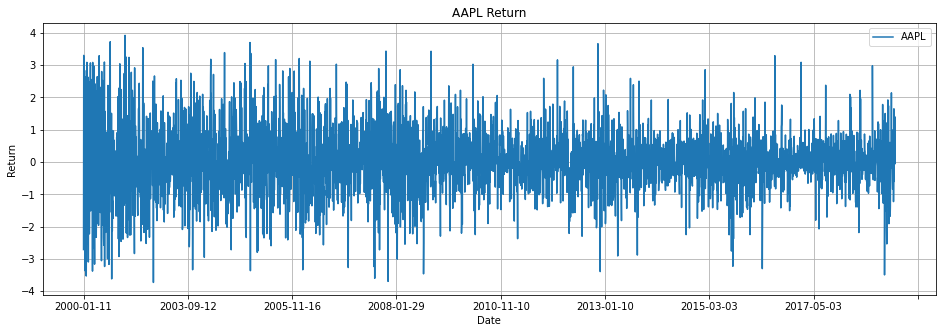

In [273]:
# Visualizing Log Returns for the DJIA 
plt.figure(figsize=(16, 5))
plt.title("AAPL Return")
plt.ylabel("Return")
rescaled_data.loc[:, "AAPL"].plot()
plt.grid(True);
plt.legend()
plt.show()

# 5. Aplicar algoritmos para el analisis

### Train Test Split

In [61]:
prop_training = int(len(rescaled_data) * 0.8)
prop_training

3113

In [63]:
X_train = rescaled_data[:prop_training]
X_test = rescaled_data[prop_training:]

X_train_raw = datareturns[:prop_training]
X_test_raw = datareturns[prop_training:]

stock_tickers = rescaled_data.columns.values
n_tickers = len(stock_tickers)

## Aplicar Analisis de Componentes Principales

In [64]:
pca = PCA()
PrincipalComponent = pca.fit(X_train)

Inspeccionemos uno de los componentes principales con el atributo `.components_`.

In [18]:
pca.components_[0]

array([-0.2278224 , -0.22835766, -0.15302828, -0.18969933, -0.20200012,
       -0.17810558, -0.19508121, -0.16845303, -0.20820442, -0.19308548,
       -0.20879404, -0.20231768, -0.19939638, -0.19521427, -0.16686975,
       -0.22806024, -0.15153408, -0.169941  , -0.19367262, -0.17118841,
       -0.18993347, -0.16805969, -0.197612  , -0.22658993, -0.13821257,
       -0.16688803, -0.16897835, -0.16070821])

### Analisis de la varianza explicada por los PC

In [110]:
pca.explained_variance_ratio_

array([0.37034695, 0.05713222, 0.04354582, 0.03974725, 0.03521035,
       0.03145037, 0.02905596, 0.02786764, 0.02748715, 0.0252315 ,
       0.0245068 , 0.0238662 , 0.02240071, 0.02112769, 0.02027904,
       0.02020582, 0.01934608, 0.01912025, 0.01808923, 0.01773868,
       0.01678349, 0.01562775, 0.015296  , 0.01448167, 0.0141177 ,
       0.01237055, 0.01080727, 0.00675988])

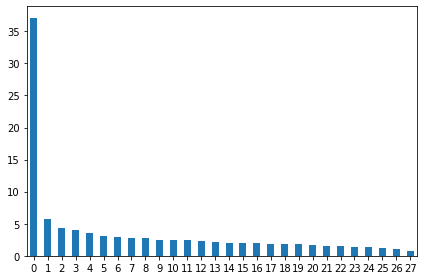

In [109]:
varianza_explicada = pd.Series(pca.explained_variance_ratio_) * 100
varianza_explicada.plot(kind='bar', rot=0)
plt.tight_layout()

Encontramos que el factor mas importante explica alrededor del 40% de la variacion de la rentabilidad diaria. El factor dominante puede interpretarse como el factor de "mercado", dependiendo de su dominancia. Esto debe ser verificado con mayor analisis.

In [275]:
varianza_explicada

0     37.034695
1      5.713222
2      4.354582
3      3.974725
4      3.521035
5      3.145037
6      2.905596
7      2.786764
8      2.748715
9      2.523150
10     2.450680
11     2.386620
12     2.240071
13     2.112769
14     2.027904
15     2.020582
16     1.934608
17     1.912025
18     1.808923
19     1.773868
20     1.678349
21     1.562775
22     1.529600
23     1.448167
24     1.411770
25     1.237055
26     1.080727
27     0.675988
dtype: float64

In [276]:
varianza_explicada_acumulada = varianza_explicada.cumsum()
varianza_explicada_acumulada

0      37.034695
1      42.747917
2      47.102498
3      51.077223
4      54.598258
5      57.743294
6      60.648891
7      63.435655
8      66.184370
9      68.707520
10     71.158200
11     73.544820
12     75.784891
13     77.897660
14     79.925564
15     81.946146
16     83.880754
17     85.792779
18     87.601702
19     89.375570
20     91.053919
21     92.616694
22     94.146294
23     95.594461
24     97.006230
25     98.243285
26     99.324012
27    100.000000
dtype: float64

<AxesSubplot:>

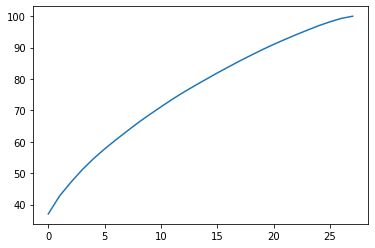

In [117]:
varianza_explicada_acumulada.plot()

Se observa que alrededor de 10 factores explican el 73% de los rendimientos del conjunto de acciones DJIA.

## Pesos de las acciones en los eigen-portfolios

Definimos funciones para determinar los pesos de cada componente principal. Luego usaremos un diagrama de dispersion para identificar el peso respectivo de cada firma en el componente principal elegido.

Elegimos un numero de *eigen portfolios* para efectuar el analisis.

In [280]:
n_portfolios = 5

Primero capturamos en un `pd.DataFrame` los componentes principales, que son la transformacion ---mediante combinacion lineal--- de los vectores originales (retornos de acciones).

In [281]:
selected_pc = pca.components_[:n_portfolios]
pc_scores = pd.DataFrame(selected_pc)
pc_scores.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,-0.227822,-0.228358,-0.153028,-0.189699,-0.202000,-0.178106,-0.195081,-0.168453,-0.208204,-0.193085,...,-0.193673,-0.171188,-0.189933,-0.168060,-0.197612,-0.226590,-0.138213,-0.166888,-0.168978,-0.160708
1,-0.023912,0.090443,0.329972,0.012329,0.083826,-0.127177,0.354454,-0.243857,0.089929,-0.148695,...,0.208012,0.002377,-0.229115,-0.295517,-0.046290,0.041226,-0.166126,-0.079850,-0.073441,-0.121831
2,-0.132978,-0.007417,0.054094,-0.160522,-0.275183,-0.510884,0.121975,0.130409,0.053872,-0.464791,...,0.112534,0.066287,0.117683,0.142559,-0.034798,-0.171249,-0.067408,0.138508,0.318069,0.170962
3,0.020452,0.295343,-0.289849,0.124549,0.044037,-0.216371,-0.223820,-0.149086,0.057387,-0.249849,...,-0.240261,0.160990,-0.145305,-0.085368,0.239176,0.071157,0.049851,-0.033902,0.096721,0.083708
4,-0.128942,0.176968,-0.046768,-0.165941,-0.152630,-0.049146,0.049341,-0.140512,0.012105,-0.049278,...,0.058591,-0.274011,0.341266,-0.167605,0.126083,-0.147708,0.078928,0.128431,-0.223797,-0.207154


Cada punto de esta tabla se conoce como *score*.

Ahora, tenemos que capturar los pesos de cada accion en los portafolios. Primero tomamos la suma de scores en cada portafolio:

In [282]:
total = pc_scores.sum(axis=1)
total

0   -5.247808
1   -0.287062
2    0.205736
3   -0.247002
4   -0.161164
dtype: float64

Calculamos el peso de cada accion como la proporcion del score total. Estos vectores de pesos asociados con la composicion de una cartera, se conocen como *eigen portfolios*.

In [283]:
eigen_portfolios = pc_scores.div(total, axis=0)
eigen_portfolios.columns = dataset.columns
eigen_portfolios

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA
0,0.043413,0.043515,0.029160,0.036148,0.038492,0.033939,0.037174,0.032100,0.039675,0.036794,...,0.036905,0.032621,0.036193,0.032025,0.037656,0.043178,0.026337,0.031801,0.032200,0.030624
1,0.083298,-0.315064,-1.149483,-0.042949,-0.292013,0.443031,-1.234765,0.849494,-0.313273,0.517989,...,-0.724625,-0.008282,0.798139,1.029455,0.161256,-0.143615,0.578711,0.278164,0.255836,0.424408
2,-0.646352,-0.036050,0.262928,-0.780230,-1.337553,-2.483195,0.592868,0.633865,0.261850,-2.259157,...,0.546979,0.322194,0.572010,0.692919,-0.169139,-0.832369,-0.327644,0.673230,1.546002,0.830978
3,-0.082799,-1.195715,1.173469,-0.504244,-0.178285,0.875990,0.906147,0.603584,-0.232335,1.011528,...,0.972710,-0.651777,0.588274,0.345616,-0.968318,-0.288085,-0.201823,0.137254,-0.391580,-0.338896
4,0.800067,-1.098066,0.290187,1.029642,0.947050,0.304943,-0.306151,0.871858,-0.075110,0.305765,...,-0.363547,1.700201,-2.117512,1.039964,-0.782327,0.916506,-0.489739,-0.796896,1.388629,1.285363


Grafiquemos las contribuciones de cada accion a los *eigenvectors*.

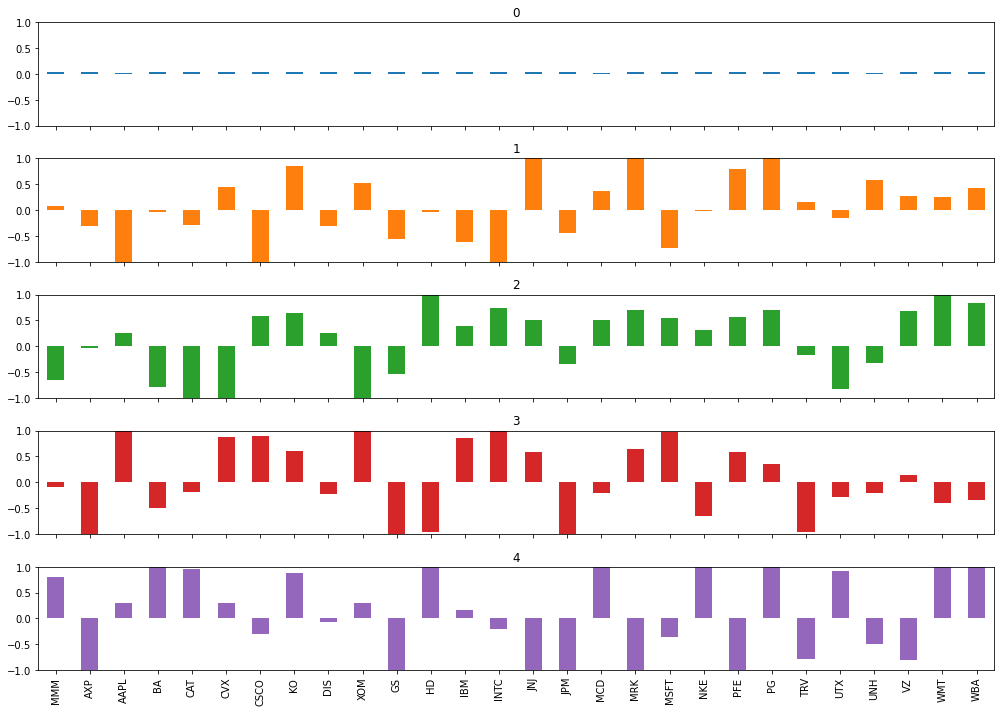

In [286]:
np.sqrt(pca.explained_variance_)
eigen_portfolios.T.plot.bar(subplots=True, layout=(int(n_portfolios),1), figsize=(14,10), legend=False, sharey=True, ylim= (-1,1))
plt.tight_layout()

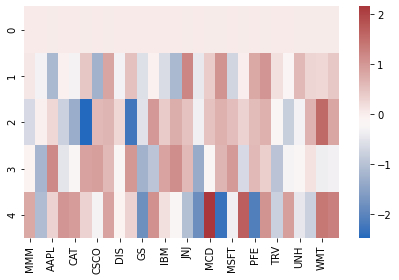

In [285]:
sns.heatmap(eigen_portfolios, cmap='vlag')
plt.tight_layout()

## Encontrar el mejor *Eigen Portfolio*

Para encontrar los mejores *eigen portfolios* y realizar backtesting de su performance, utilizamos el indice Sharpe. Esta es una métrica de rendimiento que explica los rendimientos anualizados frente a la volatilidad anualizada de cada empresa en una cartera. 

Un indice de Sharpe alto explica retornos mas altos y/o volatilidad mas baja para la cartera especificada. El indice de Sharpe anualizado se calcula dividiendo los rendimientos anualizados contra la volatilidad anualizada:

- Para la rentabilidad anualizada aplicamos la media geometrica de todas las rentabilidades con respecto a los periodos por ano. 
- La volatilidad anualizada se calcula comoe el producto de la desviacion estandar de los rendimientos y por la raiz cuadrada de los periodos por ano.

In [163]:
def sharpe_ratio(ts_returns, periods_per_year=252):
    '''
    Calcula: (i) el retorno anualizado; (ii) la volatilidad anualizada y (iii) el sharpe ratio.
    
    ts_returns: retornos de un eigen portfolio.
    periods_per_year: numero de periodos operativos de la bolsa en un ano.
    '''
    n_years = ts_returns.shape[0] / periods_per_year
    annualized_return = np.power(np.prod(1 + ts_returns), (1 / n_years))-1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

Usamos un loop para calcular los pesos de los componentes principales en cada *eigen portfolio*. Luego se usa la función `sharpe_ratio()` definida anteriormente para encontrar el portafolio con el *sharpe ratio* mas alto.

<ipython-input-163-587571023fdb>:9: RuntimeWarning: invalid value encountered in power
  annualized_return = np.power(np.prod(1 + ts_returns), (1 / n_years))-1
El eigen portfolio #0 tiene el mayor sharpe. ret = 11.47%, volatilidad = 13.31%, sharpe = 0.86
         Ret       vol    sharpe
0   0.114739  0.133133  0.861838
7   0.095771  0.693481  0.138102
5   0.100020  0.844943  0.118375
1   0.056561  0.670429  0.084366
2  -0.106559  0.858820 -0.124076
11 -1.000000  7.227664 -0.138357
13 -0.399292  2.069889 -0.192905
25 -1.000000  5.009294 -0.199629
23 -1.000000  4.955034 -0.201815
6  -0.416203  1.967123 -0.211580
10 -0.157622  0.738399 -0.213465
3  -0.162130  0.738014 -0.219684
26 -0.999993  4.535175 -0.220497
8  -0.422215  1.396786 -0.302276
17 -0.998332  3.277252 -0.304625
24 -0.550144  1.728886 -0.318207
16 -0.980029  3.037992 -0.322591
21 -0.470440  1.420469 -0.331187
14 -0.886228  2.571136 -0.344684
27 -0.932511  2.605850 -0.357853


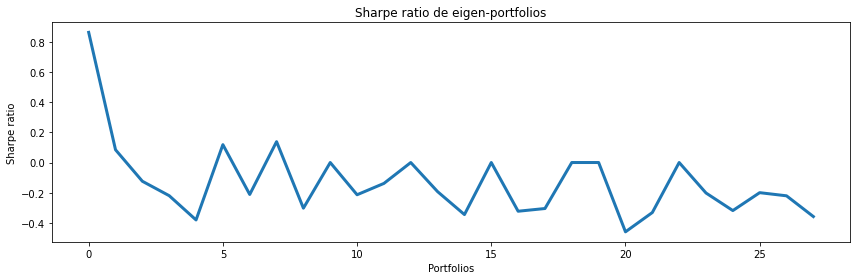

In [166]:
def portfolio_optimization():
    n_portfolios = len(pca.components_)
    
    # generar vectores de metricas con 0 (se ira completando con cada iteracion)
    annualized_ret = np.array([0.] * n_portfolios) 
    annualized_vol = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)

    # iinicializar el maximo sharpe en 0 (se actualiza con cada iteracion)
    highest_sharpe = 0 
    stock_tickers = rescaled_data.columns.values
    n_tickers = len(stock_tickers)
    pcs = pca.components_
    

    for i in range(n_portfolios):
        
        pc_w = pcs[i] / sum(pcs[i])
        eigen_prtfi = pd.DataFrame(data ={'weights': pc_w.squeeze() * 100}, index = stock_tickers)
        eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)
        eigen_prti_returns = np.dot(X_train_raw.loc[:, eigen_prtfi.index], pc_w)
        eigen_prti_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_train_raw.index)
        er, vol, sharpe = sharpe_ratio(eigen_prti_returns)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe
        sharpe_metric= np.nan_to_num(sharpe_metric)
        
    # encontrar el portafolio con el mayor sharpe ratio
    highest_sharpe = np.argmax(sharpe_metric)

    print('El eigen portfolio #%d tiene el mayor sharpe. ret = %.2f%%, volatilidad = %.2f%%, sharpe = %.2f' % 
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100, 
           annualized_vol[highest_sharpe]*100, 
           sharpe_metric[highest_sharpe]))


    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio de eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

    results = pd.DataFrame(data={'Ret': annualized_ret, 'vol': annualized_vol, 'sharpe': sharpe_metric})
    results.dropna(inplace=True)
    results.sort_values(by=['sharpe'], ascending=False, inplace=True)
    print(results.head(20))

    plt.tight_layout()

portfolio_optimization()

Los resultados muestran que el *eigen portfolio* 0 tiene el mejor performance, con mayor retorno y menor volatiilidad.

In [287]:
def pc_weights():
    """
    Calcula los pesos de los vectores originales en cada uno de los componentes principales. 
    Requiere una modelo PCA entrenado y con nombre 'pca'.
    """
    weights = pd.DataFrame()
    for i in range(len(pca.components_)):
        weights["weights_{}".format(i)] = pca.components_[i] / sum(pca.components_[i])
    weights = weights.values.T
    return weights
weights = pc_weights()

In [292]:
weights_df = pd.DataFrame(weights).head()

capturamos los pesos del eigenportfolio 0:

In [175]:
epf_0_weights = weights[0]
epf_0_weights

array([0.04341287, 0.04351486, 0.02916042, 0.0361483 , 0.03849228,
       0.03393904, 0.03717385, 0.03209969, 0.03967455, 0.03679355,
       0.0397869 , 0.0385528 , 0.03799613, 0.0371992 , 0.03179799,
       0.04345819, 0.02887569, 0.03238323, 0.03690543, 0.03262094,
       0.03619291, 0.03202474, 0.0376561 , 0.04317801, 0.0263372 ,
       0.03180147, 0.0321998 , 0.03062387])

In [197]:
portfolio = pd.DataFrame()
def get_weights(weights, portfolio=portfolio):
    portfolio = pd.DataFrame(data ={'weights': weights.squeeze()*100}, index = stock_tickers) 
    portfolio.sort_values(by=['weights'], ascending=False, inplace=True)
    return portfolio

In [208]:
pesos_portfolio = get_weights(weights=epf_0_weights)
pesos_portfolio

,weights
AXP,4.351486
JPM,4.345819
MMM,4.341287
UTX,4.317801
GS,3.978690
DIS,3.967455
HD,3.855280
CAT,3.849228
IBM,3.799613
TRV,3.765610


In [293]:
weights_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.043413,0.043515,0.029160,0.036148,0.038492,0.033939,0.037174,0.032100,0.039675,0.036794,...,0.036905,0.032621,0.036193,0.032025,0.037656,0.043178,0.026337,0.031801,0.032200,0.030624
1,0.083298,-0.315064,-1.149483,-0.042949,-0.292013,0.443031,-1.234765,0.849494,-0.313273,0.517989,...,-0.724625,-0.008282,0.798139,1.029455,0.161256,-0.143615,0.578711,0.278164,0.255836,0.424408
2,-0.646352,-0.036050,0.262928,-0.780230,-1.337553,-2.483195,0.592868,0.633865,0.261850,-2.259157,...,0.546979,0.322194,0.572010,0.692919,-0.169139,-0.832369,-0.327644,0.673230,1.546002,0.830978
3,-0.082799,-1.195715,1.173469,-0.504244,-0.178285,0.875990,0.906147,0.603584,-0.232335,1.011528,...,0.972710,-0.651777,0.588274,0.345616,-0.968318,-0.288085,-0.201823,0.137254,-0.391580,-0.338896
4,0.800067,-1.098066,0.290187,1.029642,0.947050,0.304943,-0.306151,0.871858,-0.075110,0.305765,...,-0.363547,1.700201,-2.117512,1.039964,-0.782327,0.916506,-0.489739,-0.796896,1.388629,1.285363


## Backtesting de eigen portfolios

El paso final es comparar el retorno de los eigen portfolios en la data de *test* para ver si el performance se mantiene.

In [298]:
def backtest(eigen):
    """
    Plot del retorno del componente principal (eigen portfolio) versus retornos de una cartera con pesos iguales (base index).
    """
    eigen_prtfi = pd.DataFrame(data ={'weights': eigen.squeeze()}, index = stock_tickers)
    eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)    

    eigen_prti_returns = np.dot(X_test_raw.loc[:, eigen_prtfi.index], eigen)
    eigen_portfolio_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_test_raw.index)
    returns, vol, sharpe = sharpe_ratio(eigen_portfolio_returns)  
    print('Current Eigen-Portfolio: Ret = %.2f%%, Vol = %.2f%%, Sharpe = %.2f' % (returns * 100, vol * 100, sharpe))
    equal_weight_return=(X_test_raw * (1/len(pca.components_))).sum(axis=1)    
    df_plot = pd.DataFrame({'Eigen portfolio': eigen_portfolio_returns, 'DJIA': equal_weight_return}, index=X_test.index)
    np.cumprod(df_plot + 1).plot(figsize=(12,5), linewidth=3)
    plt.tight_layout()

Current Eigen-Portfolio: Ret = 23.20%, Vol = 11.27%, Sharpe = 2.06


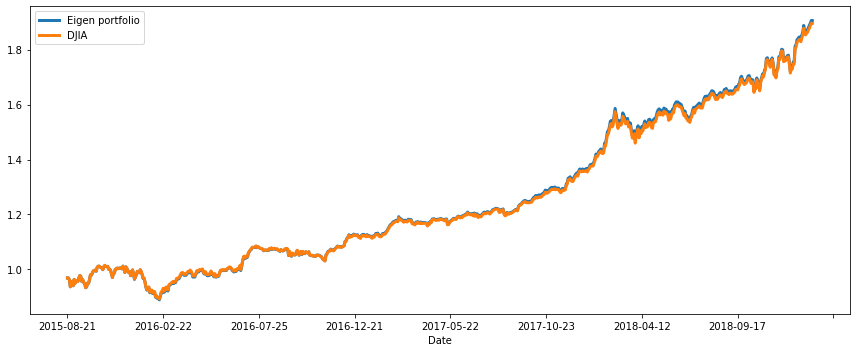

In [299]:
backtest(eigen=weights[0])

Current Eigen-Portfolio: Ret = 99.80%, Vol = 58.34%, Sharpe = 1.71


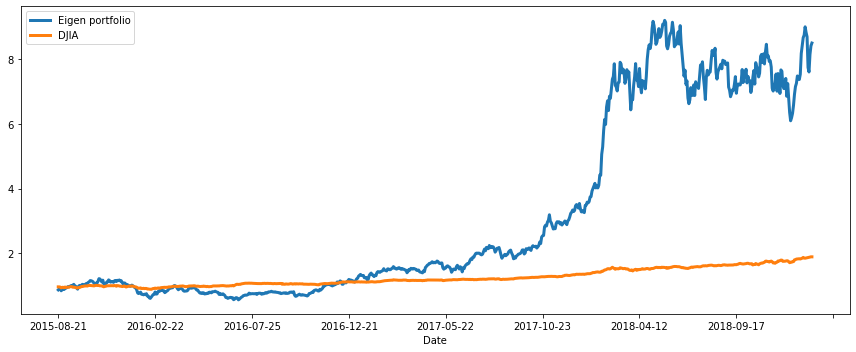

In [301]:
backtest(eigen=weights[1])

Current Eigen-Portfolio: Ret = 89.81%, Vol = 206.53%, Sharpe = 0.43


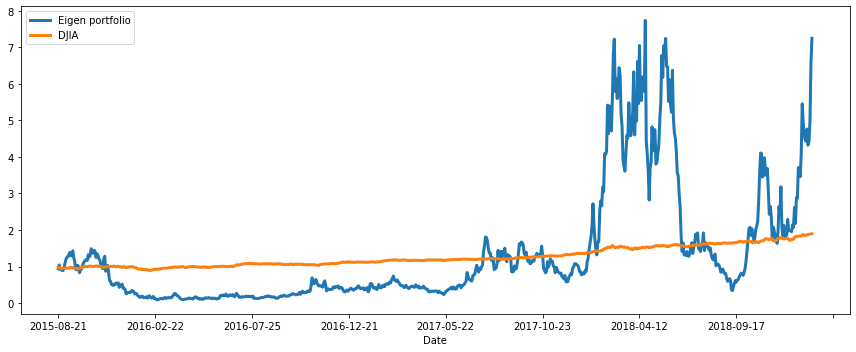

In [300]:
backtest(eigen=weights[27])